# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from scipy import stats as st

In [2]:
pd.set_option('display.max_row', 30) # максимальное количество выводимых строк - 30
pd.options.display.float_format="{:,.3f}".format # количество знаков после запятой - 3
pd.options.mode.chained_assignment = None

In [3]:
# загружаем данныкъе 

geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')


**Изучим данные на пропуски, явные и неявные дубликаты, корреляцию признаков и описательную статистику.**

In [4]:
geo_data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037
5,wX4Hy,0.970,0.490,-0.735,64.742
6,tL6pL,0.645,0.531,1.780,49.055
7,BYPU6,-0.401,0.808,-5.625,72.943
8,j9Oui,0.643,-0.552,2.372,113.356
9,OLuZU,2.173,0.564,9.442,127.911


In [5]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
geo_data_0.duplicated().sum()

0

In [7]:
geo_data_0[geo_data_0.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.085,-0.312,6.991,127.643
64022,74z30,0.741,0.459,5.153,140.771
51970,A5aEY,-0.180,0.936,-2.095,33.020
3389,A5aEY,-0.040,0.157,0.210,89.249
69163,AGS9W,-0.934,0.116,-3.656,19.230
42529,AGS9W,1.455,-0.480,0.683,126.371
931,HZww2,0.755,0.369,1.863,30.682
7530,HZww2,1.061,-0.374,10.430,158.829
63593,QcMuo,0.636,-0.473,0.863,64.579
1949,QcMuo,0.507,-0.324,-2.216,75.497


In [8]:
geo_data_0[geo_data_0.duplicated(subset='id', keep='first')].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.085,-0.312,6.991,127.643
51970,A5aEY,-0.180,0.936,-2.095,33.020
69163,AGS9W,-0.934,0.116,-3.656,19.230
7530,HZww2,1.061,-0.374,10.430,158.829
63593,QcMuo,0.636,-0.473,0.863,64.579
75715,Tdehs,0.112,0.430,3.219,60.964
92341,TtcGQ,0.111,1.023,0.911,101.318
97785,bsk9y,0.378,0.006,0.161,160.637
41724,bxg6G,-0.824,0.546,3.630,93.008
90815,fiKDv,0.050,0.841,6.395,137.347


In [9]:
geo_data_0[geo_data_0.duplicated(subset='id', keep='last')].sort_values(by='id')

,id,f0,f1,f2,product
64022,74z30,0.741,0.459,5.153,140.771
3389,A5aEY,-0.040,0.157,0.210,89.249
42529,AGS9W,1.455,-0.480,0.683,126.371
931,HZww2,0.755,0.369,1.863,30.682
1949,QcMuo,0.507,-0.324,-2.216,75.497
21426,Tdehs,0.829,0.299,-0.050,96.035
60140,TtcGQ,0.569,-0.105,6.440,85.350
89582,bsk9y,0.399,-0.400,10.122,163.433
1364,bxg6G,0.412,0.857,-3.653,73.604
16633,fiKDv,0.157,1.028,5.586,95.818


In [10]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id', keep='first').sort_values(by='id')
geo_data_0.shape

(99990, 5)

In [11]:
geo_data_0.describe()

,f0,f1,f2,product
count,"99,990.000","99,990.000","99,990.000","99,990.000"
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.288
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.497
50%,0.502,0.250,2.516,91.848
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


In [12]:
geo_data_0.corr()

,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


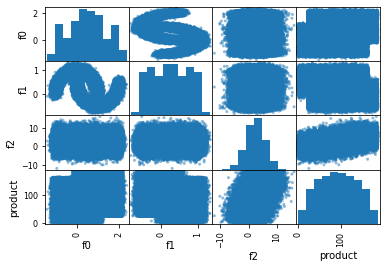

In [13]:
pd.plotting.scatter_matrix(geo_data_0);

In [14]:
geo_data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766
5,HHckp,-3.328,-2.205,3.004,84.039
6,h5Ujo,-11.143,-10.133,4.002,110.992
7,muH9x,4.235,-0.001,2.005,53.907
8,YiRkx,13.355,-0.332,4.999,134.766
9,jG6Gi,1.069,-11.026,4.998,137.945


In [15]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [16]:
geo_data_1.duplicated().sum()

0

In [17]:
geo_data_1[geo_data_1.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435,-12.296,2.000,57.086
84461,5ltQ6,18.214,2.192,3.994,107.813
1305,LHZR0,11.171,-1.945,3.003,80.860
41906,LHZR0,-8.990,-4.287,2.009,57.086
2721,bfPNe,-9.494,-5.464,4.006,110.992
82178,bfPNe,-6.203,-4.820,2.995,84.039
47591,wt4Uk,-9.091,-8.109,-0.002,3.179
82873,wt4Uk,10.260,-9.376,4.994,134.766


In [18]:
geo_data_1 = geo_data_1.drop_duplicates(subset='id', keep='first').sort_values(by='id')
geo_data_1.shape

(99996, 5)

In [19]:
geo_data_1.describe()

,f0,f1,f2,product
count,"99,996.000","99,996.000","99,996.000","99,996.000"
mean,1.141,-4.797,2.495,68.824
std,8.966,5.120,1.704,45.945
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


In [20]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.031
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.031,-0.010,0.999,1.000


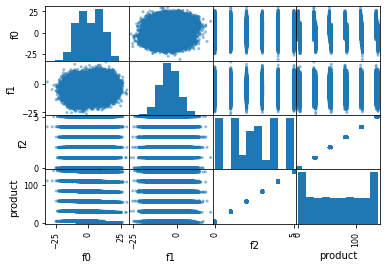

In [21]:
pd.plotting.scatter_matrix(geo_data_1);

In [22]:
geo_data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601
5,LzZXx,-0.758,0.711,2.586,90.222
6,WBHRv,-0.575,0.318,1.774,45.641
7,XO8fn,-1.907,-2.458,-0.177,72.481
8,ybmQ5,1.776,-0.279,3.004,106.617
9,OilcN,-1.214,-0.439,5.923,52.955


In [23]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [24]:
geo_data_2.duplicated().sum()

0

In [25]:
geo_data_2[geo_data_2.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.232,-1.699,4.991,11.716
55967,KUPhW,1.211,3.176,5.544,132.832
11449,VF7Jo,2.123,-0.858,5.746,181.717
49564,VF7Jo,-0.883,0.561,0.724,136.233
44378,Vcm5J,-1.229,-2.439,1.223,137.968
95090,Vcm5J,2.588,1.987,2.482,92.328
28039,xCHr8,1.633,0.368,-2.378,6.121
43233,xCHr8,-0.847,2.102,5.597,184.389


In [26]:
geo_data_2 = geo_data_2.drop_duplicates(subset='id', keep='first').sort_values(by='id')

In [27]:
geo_data_2.shape

(99996, 5)

In [28]:
geo_data_2.describe()

,f0,f1,f2,product
count,"99,996.000","99,996.000","99,996.000","99,996.000"
mean,0.002,-0.002,2.495,94.998
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.010,2.484,94.925
75%,1.158,1.164,4.859,130.587
max,7.238,7.845,16.739,190.030


In [29]:
geo_data_2.corr()

,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


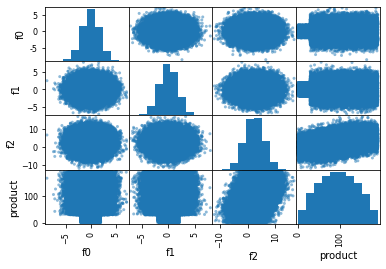

In [30]:
pd.plotting.scatter_matrix(geo_data_2);

### Вывод

- В данных выявлены и удалены неявные дубликаты по стоблцу `id` в котором записан уникальный индентификатор скважин.
- В первом и третьем регионах в столбце `product` среднее и медианное значение близки, что говорит об отсутствии выбрасов.
- Во втором регионе среднее значение в столбце `product` выше медианного на основе чего можно сделать выводы о выбросах в большую сторону (некоторые скважины имеют большей запас нефти).
- В первом и третьем регионах видна сильная корреляция между признаком `f2` и `product` равная 0.44 и 0,48 соответственно. Во втором региони рорреляция очень сильная и равняется 0,99.

## Обучение и проверка модели

### Разделим данные на тренитовочную и тестовую выборки, проведем масштабирование данных и обучим модель.

#### Регион №1

In [31]:
# разделим данные на признаки объектов и целевой признак

features_0 = geo_data_0.drop(['product', 'id'], axis=1)
target_0 = geo_data_0['product']

# проведем масштабирование признаков объекта

scaler = StandardScaler()
scaler.fit(features_0)
features_0 = scaler.transform(features_0)

# разделим данные на тренировочную и тестовую выборки

features_train_0, features_test_0, target_train_0, target_test_0 = train_test_split(features_0,
                                                                                    target_0,
                                                                                    test_size=0.25,
                                                                                    random_state=42)

# обучим модель

model = LinearRegression()
model.fit(features_train_0, target_train_0)
predictions_0 = model.predict(features_test_0)
print('Средний запас предсказанного сырья:', predictions_0.mean())
print('RMSE:', (mean_squared_error(target_test_0, predictions_0))**0.5)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_0, target_train_0)

print('RMSE Dummy модели:', (mean_squared_error(target_test_0, dummy_model.predict(features_test_0)))**0.5)


Средний запас предсказанного сырья: 92.4584480925884
RMSE: 37.61829662550861
RMSE Dummy модели: 44.27898560044623


#### Регион №2

In [32]:
# разделим данные на признаки объектов и целевой признак

features_1 = geo_data_1.drop(['product', 'id'], axis=1)
target_1 = geo_data_1['product']

# проведем масштабирование признаков объекта

scaler = StandardScaler()
scaler.fit(features_1)
features_1 = scaler.transform(features_1)

# разделим данные на тренировочную и тестовую выборки

features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split(features_1,
                                                                                    target_1,
                                                                                    test_size=0.25,
                                                                                    random_state=42)

# обучим модель

model = LinearRegression()
model.fit(features_train_1, target_train_1)
predictions_1 = model.predict(features_test_1)
print('Средний запас предсказанного сырья:', predictions_1.mean())
print('RMSE:', (mean_squared_error(target_test_1, predictions_1))**0.5)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_1, target_train_1)

print('RMSE Dummy модели:', (mean_squared_error(target_test_1, dummy_model.predict(features_test_1)))**0.5)


Средний запас предсказанного сырья: 68.84677355427276
RMSE: 0.8879569829575956
RMSE Dummy модели: 45.94430954836186


#### Регион №3

In [33]:
# разделим данные на признаки объектов и целевой признак

features_2 = geo_data_2.drop(['product', 'id'], axis=1)
target_2 = geo_data_2['product']

# проведем масштабирование признаков объекта

scaler = StandardScaler()
scaler.fit(features_2)
features_2 = scaler.transform(features_2)

# разделим данные на тренировочную и тестовую выборки

features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(features_2,
                                                                                    target_2,
                                                                                    test_size=0.25,
                                                                                    random_state=42)

# обучим модель

model = LinearRegression()
model.fit(features_train_2, target_train_2)
predictions_2 = model.predict(features_test_2)
print('Средний запас предсказанного сырья:', predictions_2.mean())
print('RMSE:', (mean_squared_error(target_test_2, predictions_2))**0.5)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_2, target_train_2)

print('RMSE Dummy модели:', (mean_squared_error(target_test_2, dummy_model.predict(features_test_2)))**0.5)


Средний запас предсказанного сырья: 94.91525751397036
RMSE: 39.85513889475951
RMSE Dummy модели: 44.52803136413859


### Вывод

- Средний запас предсказанного сырья в регионах имеет очень близкое значение к фактическим средним запасам.
- Лучший показаетель оценки качества модели RMSE во втором регионе со значением 0.88.
- Наибольший запас сырья в третьем регионе с показателем среднего значения 94.91.
- Во всех регионах модель показывает результат метрики RMSE лучше чем dummy модель, котораяя предсказывает всегда среднее значение.

## Подготовка к расчёту прибыли

In [34]:
INCOME = 450 # доход с одной единицы сырья в тысячах 
BUDGET = 10000000 # бюджет на разработку скважин в тысячах
N = 200 # количество точек для разработки

min_product = BUDGET/INCOME/N
print('Минимальный средний объем:', min_product)

Минимальный средний объем: 111.11111111111111


**ВЫВОД: минимальный средний объем продукта скважин достаточный для разработки равен 111.11 тысяч баррелей.**
Средний показатель запасов в первом и третьем регионах наиболее близки к данному расчету. Также в этих регионах 75 квартиль примерно равен 130 тысячам барелей, что является достаточным для разработки.

## Функцию для расчёта прибыли

In [35]:
def profit(target, predict):
    
    # подготовка данных
    
    df = target.to_frame()
    df_2 = pd.Series(predict, index=target.index).to_frame()
    df['predict'] = df_2
    df = df.sort_values(by='predict', ascending=False)
    
    df = df[:N] # скважины с максимальным предсказанием
    
    total_product = df['product'].sum() # общий объем сырья
    profits = total_product * INCOME - BUDGET # прибыль для полученного объемы сырья
    
    return f'{profits:.2f}'

In [36]:
# регион №1
print('Прибыль при разработки в регионе№1:', profit(target_test_0, predictions_0))
# регион №2
print('Прибыль при разработки в регионе№2:', profit(target_test_1, predictions_1))
# регион №3
print('Прибыль при разработки в регионе№3:', profit(target_test_2, predictions_2))

Прибыль при разработки в регионе№1: 3367800.71
Прибыль при разработки в регионе№2: 2415086.70
Прибыль при разработки в регионе№3: 2365339.72


### Вывод
- Все три региона являются прибыльными пр разработки выбранных скважин.
- Наибольшую прибыль принесет первый регион равную 3 367 800 тысяч.

## Расчёт прибыли и рисков 

In [37]:
state = np.random.RandomState(12345)

def bootstrap(target, predict):
    
    # подготовка данных
    
    df = target.to_frame()
    df_2 = pd.Series(predict, index=target.index).to_frame()
    df['predict'] = df_2
    
    values = []
    
    for i in range(1000):
        subsample = (
            df.sample(500, replace=True, random_state=state)
            .sort_values(by='predict', ascending=False)[:N]
                    )
        total_product = subsample['product'].sum() * INCOME - BUDGET
        values.append(total_product)
        
    values = pd.Series(values)
    lower = values.quantile(.025)
    apper = values.quantile(.975)
    
    print(f'Средняя прибыль: {values.mean():.2f}')
    print(f'Риск убытков: {(values<0).mean():.2%}')
    print(f'95% доверительный интервал: {lower:.2f} - {apper:.2f} тысяч.')

### Риски и прибыль для региона №1

In [38]:
bootstrap(target_test_0, predictions_0)

Средняя прибыль: 414090.45
Риск убытков: 5.60%
95% доверительный интервал: -74255.10 - 936301.91 тысяч.


### Риски и прибыль для региона №2

In [39]:
bootstrap(target_test_1, predictions_1)

Средняя прибыль: 452932.19
Риск убытков: 1.10%
95% доверительный интервал: 86013.94 - 874432.59 тысяч.


### Риски и прибыль для региона №3

In [40]:
bootstrap(target_test_2, predictions_2)

Средняя прибыль: 375655.17
Риск убытков: 6.60%
95% доверительный интервал: -156905.23 - 895232.24 тысяч.


## Вывод

- Второй регион наиболее предпочтительный для дальнейшей разработки скважин.
- Модель во втором региони предсказывает значения целевого признака максимально близкие к реальным данным в то время как в первом и третьем регионах срезднее отклонение предсказания равняется 37 и 39 пр и средних значениях в 92 и 94 баррелей, что является погрешностью примерно в 40%.
- При применении техники Bootstrap риск убытков во втором регионее равен 1% в то время как в первом и третьем регионах риск значительно выше 5.6% и 6.6% соответственно.
- 95% доверительный интервал в первом и третьем регионах имеет отрицательные значения от 0.25 квартиля. Во втором регионе 95% доверительный интервал не имеет отрицательных значений прибыли.
- Во втором регионе средняя прибыль при применении техники Bootstrap равна 452932.19, что выше в двух других регионах.